Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


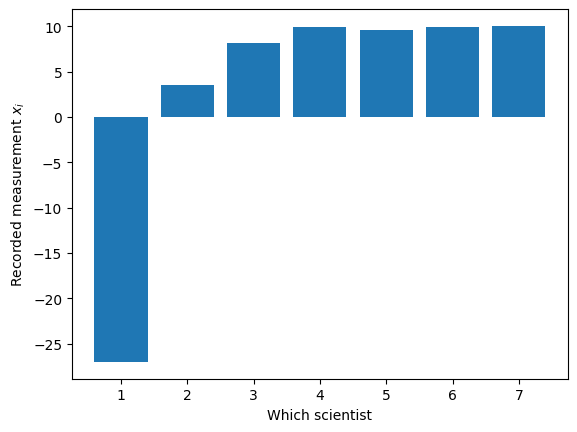

In [10]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25988/1639954671.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipykernel_25988/1639954671.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$p(\sigma)$")


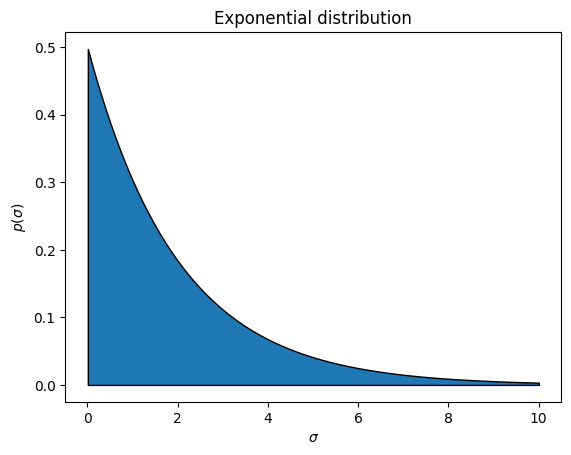

In [11]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [12]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)

    # First return -inf if sigma <= 0
    if torch.any(sigma <= 0):
        return -np.inf
    
    # First define the log probability variable we will be returning
    log_p = 0
    
    # Start by adding the Normal probability for mu
    log_p += dist.Normal(loc = 0.0, scale = alpha).log_prob(mu)

    # Proceed with the seven sigmas
    log_p += dist.Exponential(beta).log_prob(sigma).sum()
    
    # Proceed with the seven x_i
    x_i = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056]) #need to load the x_i tensor, x not given as variable in function
    log_p += dist.Normal(loc = mu, scale = sigma).log_prob(x_i).sum()

    return log_p #As defined in function, we want it to return a scalar (I'm assuming one value torch tensor)

# I try to conduct some testing:
example_sigma = torch.FloatTensor([1,2,3,4,5,6,7])
example_mu = torch.tensor(3.0)
log_joint(example_mu, example_sigma, alpha=50, beta=0.5)

tensor(-494.3173)

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [13]:
# (GRADING)

In [14]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [15]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    # I decide to make both proposals a Gaussian centered around current values and with hopefully good enough standard deviation
    # Why Gaussian? Symmetry, to make the rejection kernel easier.
    # Hopefully good enough standard deviation? I do not want a sd big enough to "jump over" the desired final results, and not
    # small enough to take a long time to converge to the desired final results. I need to find sd that is "just right".

    # Start with q_mu
    mu_sd = 0.25 # After running it with different sd, I found this value to acquire 0.3 to 0.4 acceptance rate, as desired.
    q_mu = dist.Normal(loc = mu, scale = mu_sd)

    # Proceed with q_sigma
    sigma_sd = torch.tensor([1., 0.7, 0.6, 0.3, 0.2, 0.2, 0.2]) # Bigger sd for measurements that appear to have more sd in the first figure
    q_sigma = dist.Normal(loc = sigma, scale = sigma_sd)

    return q_mu, q_sigma

q_mu, q_sigma = get_mcmc_proposal(example_mu, example_sigma)
print(q_mu.sample(), q_sigma.sample())

tensor(2.4930) tensor([1.1967, 2.0512, 2.7912, 3.6088, 4.8457, 6.2264, 7.0835])


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [16]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [17]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """

    accepted = False
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)

    # Acquire proposal from q_mu
    mu_prime = q_mu.sample()

    # Acquire proposal from q_sigma
    needed_bool = True
    while needed_bool:
        sigma_prime = q_sigma.sample()
        if torch.any(sigma_prime <= 0): #If we get any of the entries to be 0 or less, sample another sigma
            continue
        else:
            needed_bool = False #If none are 0 or less, keep the proposed sigma
        
    log_A = min(1, (log_joint(mu_prime, sigma_prime, alpha, beta) - log_joint(mu, sigma, alpha, beta)))

    # Decide wether the proposed mu and sigmas are better
    if log_A >= np.log(np.random.uniform(0,1)):
        accepted = True
        mu = mu_prime
        sigma = sigma_prime
    
    return mu, sigma, accepted
mcmc_step(example_mu, example_sigma)

(tensor(3.), tensor([1., 2., 3., 4., 5., 6., 7.]), False)

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [18]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [19]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    N_samples = 5000
    N_burnin = int(0.15*N_samples)
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [20]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.4144


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_25988/2920453112.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")
/tmp/ipykernel_25988/2920453112.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")


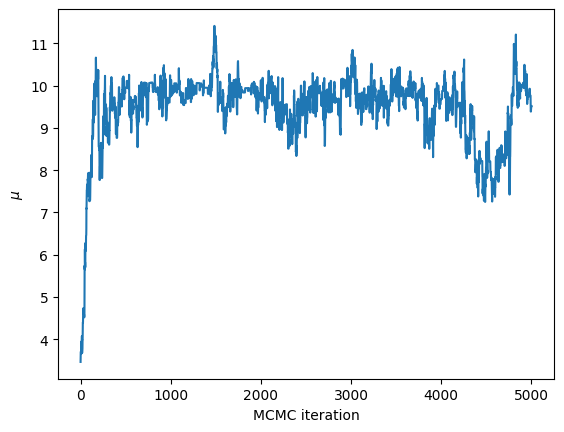

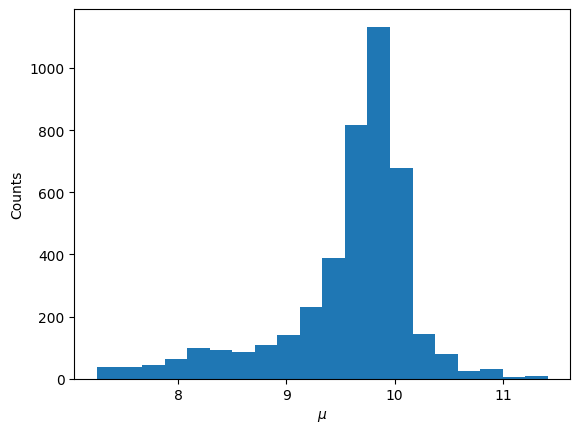

In [21]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25988/1079867295.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma_i$");


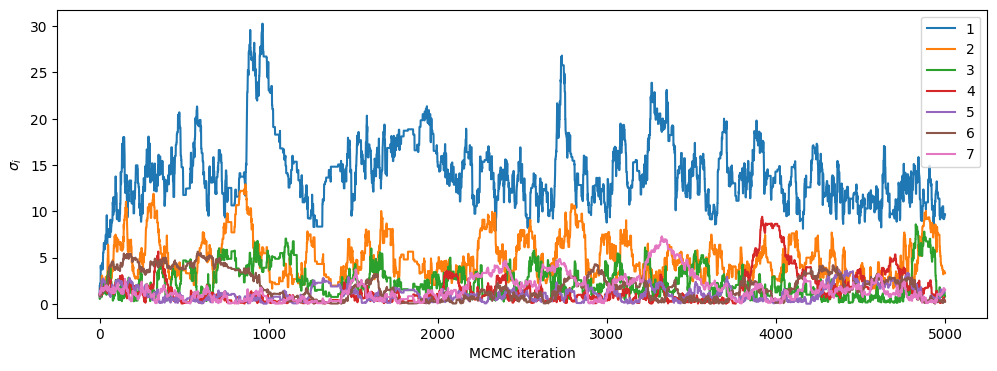

In [22]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25988/2243842497.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");
/tmp/ipykernel_25988/2243842497.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Estimated measurement std $\sigma_i$");


ValueError: List of boxplot statistics and `positions` values must have same the length

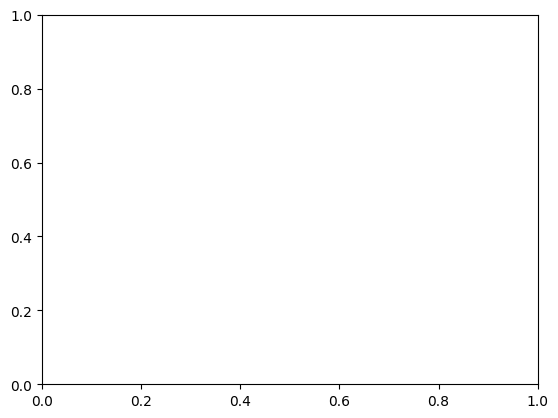

In [23]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [ ]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    # Need to return mean of mu throughout all samples of mu past burn-in

    valid_mu = mu_chain[N_burnin:]
    mu_mean = 0
    for mu in valid_mu:
        mu_mean += mu
    mu_mean = mu_mean / len(valid_mu)

    return mu_mean

    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    # Need to count all of the mu < 9 past burn_in and divide it by total number of mu past burn-in
    # Acquire number of mu < 9 past burn-in
    valid_mu = mu_chain[N_burnin:]
    mu_lt_9 = []
    for mu in valid_mu:
        if mu < 9:
            mu_lt_9.append(mu)
    
    # Acquire prob
    result = len(mu_lt_9) / len(valid_mu)
    
    return result

In [ ]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

### Question 1
The first reason why I chose a Gaussian Distribution as a proposal distribution to acquire both randomly proposed $\boldsymbol{\sigma}$ and $\mu$ is due to its symmetry: $q(\boldsymbol{\sigma}^\prime, \mu^\prime \mid \boldsymbol{\sigma}, \mu) = q(\boldsymbol{\sigma}, \mu \mid\boldsymbol{\sigma}^\prime, \mu^\prime)$. The fact that a Gaussian is symmetric allows me to simplify the rejection kernel expression and obtain an intuitive understanding of the Metropolis Hastings algorithm (in general, move to states with higher likelihood).
\
\
A more important reason to why a Gaussian is a good proposal distribution is that it is defined over the entire real line, thus allowing us to explore (with correct parametrisation) the entire posterior (given enough iterations). In other words: a good proposal distribution assigns non-zero probability of moving to states that also have non-zero probability in our posterior distribution, a Gaussian as a proposal distribution satisfies this.
\
\
In addition, I can study the acceptance rate of my MCMC proposal distribution to determine its validity. As explained in lectures, we do not want the overwhelming majority of our samples to be "wasted" by a proposal distribution that consistently proposes parameters with high probability of rejection. That will make our algorithm inefficient and will need large amounts of samples for us to converge. We want a proposal distribution that proposes sensible parameters so that it allows us to explore the desired posterior with a sensible amount of samples. As explained in lectures, a good acceptance rate for a proposal distribution is in between 25-40%, which our proposal distribution also satisfies. This is also reflected in the graph that shows $\mu$ against iterations of MCMC, we can see the burn-in phase does not take too many iterations and past burn-in phase, there is enough deviation for us to study the posterior properly.
\
\
Finally, I want to address the fact that my proposal distribution also stemmed from my prior knowledge of the model (which could be considered a bias?), since I know that our target posteriors are uni-modal. This allows me to "tune" the parameters in my proposal distribution by trial and error until they provide an appropiate acceptance rate. Evidently, the parameters were not randomly tuned, as explained in the code, I assume more standard deviation for scientists that are further away from what I (also the entire exercise) assumes the mean to be (we can see this in the very first plot).
### Question 2
I do not think component-wise proposals would be useful in our particular case where we just need to approximate the posterior distribution of 8 parameters ($\mu,\sigma_1,...,\sigma_7$). But I do think component-wise proposals could prove useful for systems with a larger amount of distribution parameters. 
\
\
If number of posterior distributions to be estimated is large, the overall chance of our MCMC proposal distribution to propose a sensible proposed parameter gets smaller as dimension of proposed parameter increases, thus making our MCMC algorithm inefficient. Let's take this exercise as an example. Currently, we have a recursive function proposing new $\sigma^\prime$, where if any entry of $\sigma^\prime \leq 0$ then propose another $\sigma^\prime$. The chances of one of the entries $\leq 0$ for a length 7 vector are small, but what if our $\boldsymbol{\sigma} \in \mathbb{R}^D$ where $D$ is large? That would make the chance for any of its entries to be $\leq 0$ to be really high, thus making our algorithm really inefficient. Thus component-wise proposals can prove really useful in these examples.
\
\
However, component-wise proposals makes our MCMC algrithm more inefficient as we need $D\times$ iterations_MCMC_non_component_wise_proposal where $D$ is the length of posterior parameters. Thus, it should not be used if not needed. In our example, $D$ is small ($D=8$), thus I would assume component_wise proposals would make our algorithm more inefficient.

#### Ignore the following cells. They are used by the grading system.

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [27]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """
    if beta < 0 or beta > 10:
        return -np.inf
    if alpha < 0 or alpha > 100:
        return -np.inf
    
    result = 0
    # Uniform distributions for both:
    result += dist.Uniform(low = 0, high = 10).log_prob(beta)
    result += dist.Uniform(low = 0, high = 100).log_prob(alpha)

    return result


In [28]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    accepted = False
    # Acquire sample proposal
    beta_sd = 0.1
    q_beta = dist.Normal(loc = beta, scale = beta_sd)

    alpha_sd = 5
    q_alpha = dist.Normal(loc = alpha, scale = alpha_sd)

    # Make sure proposed alpha and beta are valid:
    needed_bool = True
    while needed_bool:
        beta_proposal = q_beta.sample()
        alpha_proposal = q_alpha.sample()
        if beta_proposal < 0 or beta_proposal > 10 or alpha_proposal < 0 or alpha_proposal > 100:
            continue
        else:
            needed_bool = False #If correct, break loop

    # Rejection Kernel
    log_A = min(1, (log_prior_alpha_beta(alpha_proposal, beta_proposal) - log_prior_alpha_beta(alpha, beta)))
    
    # Decide
    if log_A >= np.log(np.random.uniform(0,1)):
        accepted = True
        beta = beta_proposal
        alpha = alpha_proposal

    return alpha, beta, accepted
    

### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
\
\
No, we end up acquiring results similar for $\mu$.
2. Were the original choices of $\alpha, \beta$ reasonable?
\
\
After a few runs of my MCMC algorithm, $\alpha$ appears to be less than the original choice of 50, and $\beta$ appears to be able to take multiple values without affecting the result much, if at all.
\
\
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?
Not sensitive to either particularly, as I seem to be acquiring the same $\mu$ with considerably different $\alpha$ and $\beta$ each time.

In [29]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [ ]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

In [ ]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

In [ ]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

In [ ]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)